In [1]:
import os
import json
import subprocess
import numpy as np
import pandas as pd
import pickle as pkl
import nibabel as nib
import scipy.io as sio
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.metrics import pairwise_distances
from os.path import join as pjoin
from mpl_toolkits.axes_grid1 import make_axes_locatable
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from nilearn.glm.first_level import make_first_level_design_matrix
import matplotlib.patches as patches
from scipy.spatial.distance import pdist, squareform
from scipy.stats import pearsonr

def save_ciftifile(data, filename):
    template = '/nfs/z1/zhenlab/BrainImageNet/NaturalObject/data/bold/Analysis_derivatives/ciftify/sub-core02/MNINonLinear/Results/ses-ImageNet01_task-object_run-1/ses-ImageNet01_task-object_run-1_Atlas.dtseries.nii'
    ex_cii = nib.load(template)
    if len(data.shape) > 1:
        ex_cii.header.get_index_map(0).number_of_series_points = data.shape[0]
    else:
        ex_cii.header.get_index_map(0).number_of_series_points = 1
        data = data[np.newaxis, :]
    nib.save(nib.Cifti2Image(data.astype(np.float32), ex_cii.header), filename)

mpl.rcParams['axes.linewidth'] = 2
mpl.rcParams.update({'font.size': 12, 'font.family': 'STIXGeneral', 'mathtext.fontset': 'stix'})

# define path
beta_path = '/nfs/z1/zhenlab/BrainImageNet/action/data/bold/derivatives/beta'
fmriprep_path = '/nfs/z1/zhenlab/BrainImageNet/action/data/bold/derivatives/fmriprep'
ciftify_path = '/nfs/z1/zhenlab/BrainImageNet/action/data/bold/derivatives/ciftify'
nifti_path = '/nfs/z1/zhenlab/BrainImageNet/action/data/bold/nifti'
result_path = '/nfs/z1/userhome/ZhouMing/workingdir/BIN/action/utils/HAD_code_backup/result'

/usr/local/neurosoft/anaconda3/lib/python3.8/site-packages/nilearn/glm/__init__.py:55: FutureWarning: The nilearn.glm module is experimental. It may change in any future release of Nilearn.
  warn('The nilearn.glm module is experimental. '


#### Using ISC map to localize high stability activation voxels

In [8]:
# load isc map
map_path = pjoin(result_path, 'brain_map')
isc_path = pjoin(map_path, f'isc.dtseries.nii')
isc_map = np.array(nib.load(isc_path).get_fdata().tolist()).squeeze()[:59412]
# using threshold to select high stability response voxels
thresh = 0.1
isc_thresh_loc = isc_map > thresh
print(f'Select {isc_thresh_loc.sum()} voxels')
# save threshold isc map
isc_map_save = np.zeros((91282))
isc_map_save[:59412][isc_thresh_loc] = isc_map[isc_thresh_loc]
if not os.path.exists(pjoin(map_path, f'isc_threshold_{thresh}.dtseries.nii')):
    save_ciftifile(isc_map_save, pjoin(map_path, f'isc_threshold_{thresh}.dtseries.nii'))

Select 12320 voxels


#### Define three ROI contrast to compare difference

In [2]:
def save_ciftifile(data, filename):
    template = '/nfs/z1/zhenlab/BrainImageNet/NaturalObject/data/bold/Analysis_derivatives/ciftify/sub-core02/MNINonLinear/Results/ses-ImageNet01_task-object_run-1/ses-ImageNet01_task-object_run-1_Atlas.dtseries.nii'
    ex_cii = nib.load(template)
    ex_cii.header.get_index_map(0).number_of_series_points = data.shape[0]
    nib.save(nib.Cifti2Image(data.astype(np.float32), ex_cii.header), filename)

def roi_mask(roi_name):
    """
        roi_name : list or str
    """
    # load reference info
    main_path = '/nfs/z1/zhenlab/BrainImageNet/Analysis_results/'
    roi_name_path = pjoin(main_path, 'roilbl_mmp.csv')
    roi_names = pd.read_csv(roi_name_path)
    roi = sio.loadmat(pjoin(main_path, 'MMP_mpmLR32k.mat'))['glasser_MMP']  # 1x59412

    # start load name
    roi_index = []
    if isinstance(roi_name, str):
        roi_tmp_index = roi_names.loc[roi_names.isin([f'L_{roi_name}_ROI']).any(axis=1)].index[0]+1
        roi_index.extend([roi_tmp_index, roi_tmp_index+180])
        mask = np.asarray([True if x in roi_index else False for x in roi[0]])
    else:
        for name in roi_name:
            roi_tmp_index = roi_names.loc[roi_names.isin([f'L_{name}_ROI']).any(axis=1)].index[0]+1
            roi_index.extend([roi_tmp_index, roi_tmp_index+180])
        mask = np.asarray([True if x in roi_index else False for x in roi[0]])
    return mask

# define path
main_path = '/nfs/z1/zhenlab/BrainImageNet/Analysis_results/'
utils_path = '/nfs/z1/userhome/ZhouMing/workingdir/BIN/action/utils/HAD_code_backup/data/utils'
map_path = pjoin(result_path, 'brain_map')

# EV_name = ['V1', 'V2', 'V3', 'V4']
# VT_name = ['V8', 'PIT', 'FFC', 'VVC', 'VMV1', 'VMV2', 'VMV3', ]
# DS_name = ['V3CD', 'V4t', 'LO1', 'LO2', 'LO3', 'FST', 'MST', 'MT', 'PH', 'V3A', 'V3B', 'V6', 'V6A', 'V7', 'IPS1']

roi_assign = pd.read_csv(pjoin(utils_path, 'HCP-MMP1_visual-cortex2.csv'))
# Primary_Visual and Early_Visual
EV_name = roi_assign.loc[roi_assign['ID_in_22Region'].isin([1, 2]), 'area_name'].to_list()
# Ventral_Stream_Visual and Medial_Temporal
VS_name = roi_assign.loc[roi_assign['ID_in_22Region'].isin([4, 13, 14]), 'area_name'].to_list()
# MT+_Complex
LS_name = roi_assign.loc[roi_assign['ID_in_22Region'].isin([5]), 'area_name'].to_list()
# Dorsal_Stream_Visual, Superior_Parietal, Inferior_Parietal and Posterior_Cingulate
DS_name = roi_assign.loc[roi_assign['ID_in_22Region'].isin([3, 16, 17, 18]), 'area_name'].to_list()
# # make V4 into the Ventral Stream
# VS_name.append('V4')
# EV_name.remove('V4')

roi_sum = ['EV', 'VS', 'DS', 'LS']
mask_sum = np.zeros((len(roi_sum), 59412), dtype=bool)
for roi_idx, roi in enumerate(roi_sum):
    tmp_mask = roi_mask(eval(f'{roi}_name'))
    # # Select stabilized voxels based on ISC 10% percentile in each region
    # tmp_thresh = np.percentile(isc_map[tmp_mask], select_percentile)
    # isc_thresh_loc = isc_map > tmp_thresh
    # Select stabilized voxels based on ISC thresh 0.1
    # tmp_mask = tmp_mask * isc_thresh_loc
    print('Select %d voxels in %s'%(tmp_mask.sum(), roi))
    # Save mask
    roi_map = np.zeros((1, 91282))
    roi_map[0, :59412] = tmp_mask
    # save_ciftifile(roi_map, pjoin(map_path, f'{roi}.dtseries.nii'))
    mask_sum[roi_idx] = tmp_mask.astype(dtype=bool)


Select 4193 voxels in EV
Select 3424 voxels in VS
Select 5128 voxels in DS
Select 1349 voxels in LS


#### Compute RDM to check whether obvious structure are hidden in high dimensional space

In [3]:
# Load beta for 30 subjects 
sub_names = sorted([i for i in os.listdir(beta_path) if i.startswith('sub')])
n_sub = len(sub_names)
n_class = 180
n_voxel = 59412

beta_sum_class_feature = np.zeros((n_sub, n_voxel, n_class))
beta_sum_voxel_feature = np.zeros((n_sub, n_class, n_voxel))
for sub_idx, sub_name in enumerate(sub_names):
    # define beta path
    beta_sub_path = pjoin(beta_path, sub_name, f'{sub_name}_action-beta_clean_split.npy')
    beta_sub = np.load(beta_sub_path).mean(axis=0)
    # scale when voxel as feature
    scaler_voxel_feature = StandardScaler()
    beta_sum_voxel_feature[sub_idx] = scaler_voxel_feature.fit_transform(beta_sub)
    # scale when class category as feature
    # scaler_class_feature = StandardScaler()
    # tmp_beta = beta_sub.transpose((1,0))
    # beta_sum_class_feature[sub_idx] = scaler_class_feature.fit_transform(tmp_beta)
    print(f'Finish loading {sub_name}')
# beta_average_class_feature = beta_sum_class_feature.mean(axis=0)
beta_average_voxel_feature = beta_sum_voxel_feature.mean(axis=0)


Finish loading sub-01
Finish loading sub-02
Finish loading sub-03
Finish loading sub-04
Finish loading sub-05
Finish loading sub-06
Finish loading sub-07
Finish loading sub-08
Finish loading sub-09
Finish loading sub-10
Finish loading sub-11
Finish loading sub-12
Finish loading sub-13
Finish loading sub-14
Finish loading sub-15
Finish loading sub-16
Finish loading sub-17
Finish loading sub-18
Finish loading sub-19
Finish loading sub-20
Finish loading sub-21
Finish loading sub-22
Finish loading sub-23
Finish loading sub-24
Finish loading sub-25
Finish loading sub-26
Finish loading sub-27
Finish loading sub-28
Finish loading sub-29
Finish loading sub-30


In [4]:
# sort the class order to fit the activity net rdm
sim_matrix = np.load(pjoin(result_path, 'activity_net_sim.npy'))
class_order = np.load(pjoin(result_path, 'class_order.npy'))
superclass_order = np.load(pjoin(result_path, 'superclass_order.npy'))

action_dataset_path = '/nfs/z1/userhome/ZhouMing/workingdir/BIN/action/exp/video'
class_selected = os.listdir(action_dataset_path)
class_selected.sort()

# beta_sum_sorted = np.zeros(beta_sum.shape)
# beta_class_feature = np.zeros(beta_average_class_feature.shape)
beta_voxel_feature = np.zeros(beta_average_voxel_feature.shape)
for class_idx, class_name in enumerate(class_order):
    # beta_sum_sorted[:, class_idx] = beta_sum[:, class_selected.index(class_name)]
    # beta_class_feature[:, class_idx] = beta_average_class_feature[:, class_selected.index(class_name)]
    beta_voxel_feature[class_idx] = beta_average_voxel_feature[class_selected.index(class_name)]

##### Generate pattern for each ROI in visual area and compute their RDM

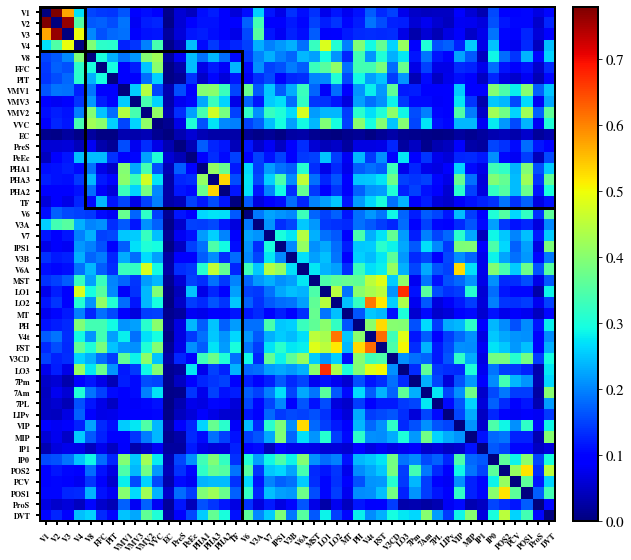

In [7]:
# define roi sum
roi_single_sum = [*EV_name, *VS_name, *DS_name]
roi_pattern = np.zeros((len(roi_single_sum), int(180*179/2)))
for roi_idx, roi in enumerate(roi_single_sum):
    tmp_mask = roi_mask(roi)
    tmp_pattern = beta_voxel_feature[:, tmp_mask]
    # roi_pattern[roi_idx] = tmp_pattern.mean(axis=0)
    # tmp_pattern = beta_voxel_feature[:, tmp_mask]
    # roi_pattern[roi_idx] = tmp_pattern.mean(axis=1)
    tmp_rdm = np.corrcoef(tmp_pattern)
    rdm_triu = tmp_rdm[np.triu_indices(tmp_rdm.shape[0], k=1)]
    roi_pattern[roi_idx] = rdm_triu

# define plot details
fig = plt.figure(figsize=(10, 10))
axes = plt.gca()
mpl.rcParams['axes.linewidth'] = 2
mpl.rcParams.update({'font.size': 14, 'font.family': 'STIXGeneral', 'mathtext.fontset': 'stix'})

# generate rdm
rdm = np.corrcoef(roi_pattern)
np.fill_diagonal(rdm, 0)
# plot rdm 
im = axes.imshow(rdm, cmap='jet') #  vmin=0, vmax=1.75
# set tick labels
axes.set_xticks(np.arange(len(roi_single_sum)))
axes.set_xticklabels(roi_single_sum, weight='bold', rotation=45)
axes.set_yticks(np.arange(len(roi_single_sum)))
axes.set_yticklabels(roi_single_sum, weight='bold')
axes.tick_params(width=2, length=4, direction="out", pad=6, labelsize=8)

# add square matrix along the diag
margin = 0.5
move_portion = 0
for roi in ['EV', 'VS', 'DS']:
    class_portion = len(eval(f'{roi}_name'))
    start_point, side_length = move_portion - margin, class_portion
    # if class_idx == 4: # make the last square show clearer
    #     side_length -= 1
    axes.add_patch(patches.Rectangle(xy=(start_point, start_point), width=side_length, height=side_length, linewidth=3,
            color='black', fill=False))
    move_portion += class_portion

# axes.set_title(f'{check_roi}', fontsize=25)
# add colorbar
divider = make_axes_locatable(axes)
cax = divider.append_axes('right', size='5%', pad=0.25)
cbar = fig.colorbar(im, cax=cax, orientation='vertical')
cbar.ax.tick_params(labelsize=15)


Finish EV 0.103
Finish VS 0.217
Finish DS 0.246
Finish LS 0.232


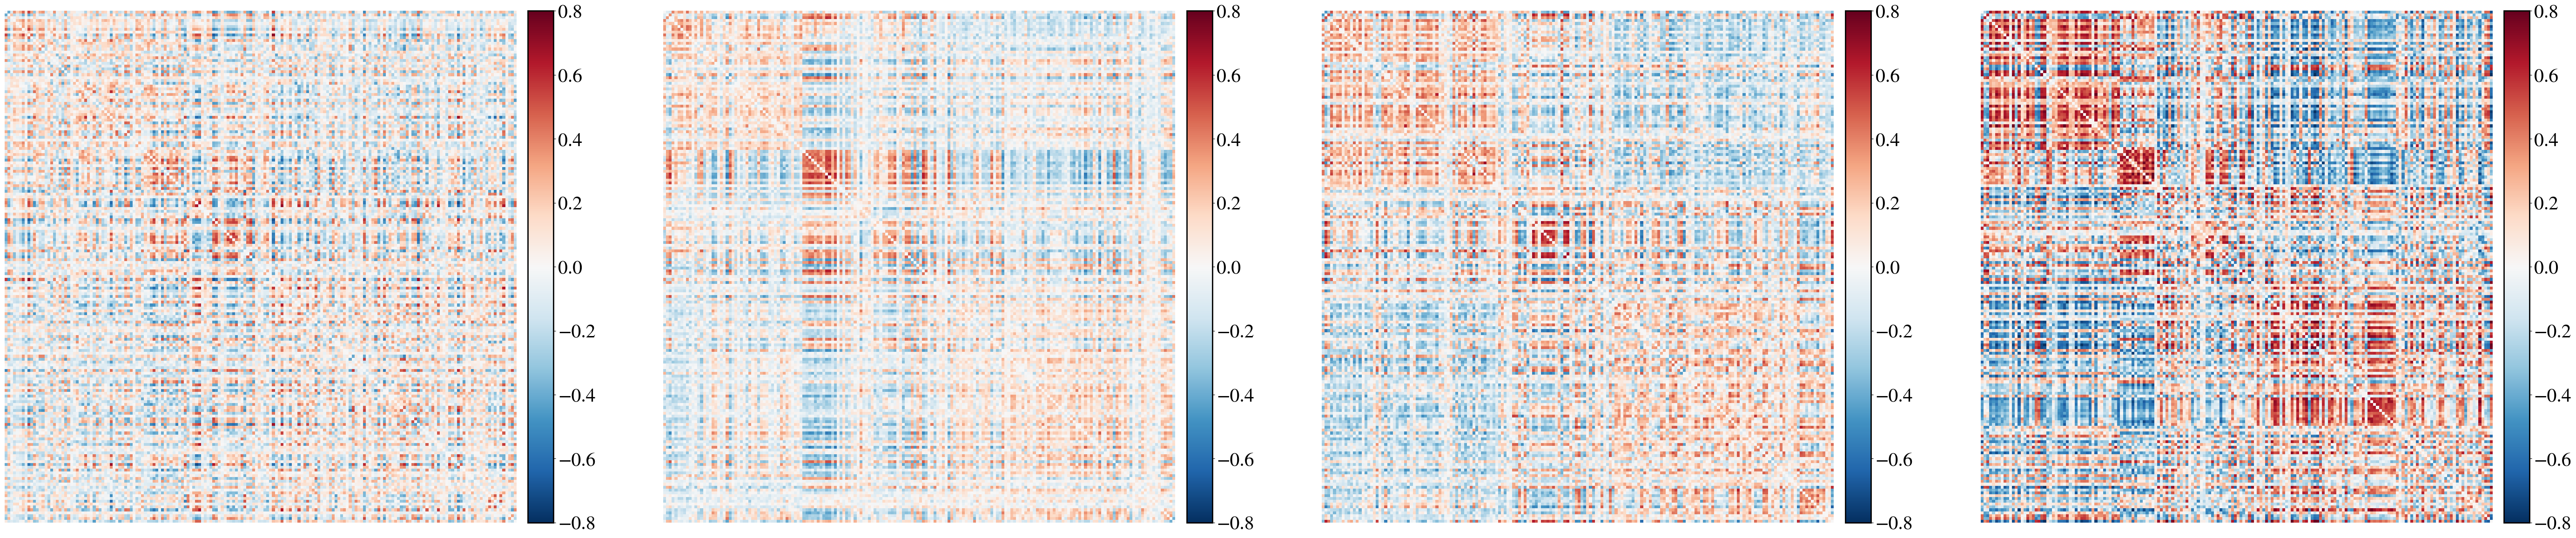

In [7]:
import matplotlib.colors as mcolors

# define plot details
fig, ax = plt.subplots(1, len(roi_sum), figsize=(70, 15))
mpl.rcParams['axes.linewidth'] = 2
mpl.rcParams.update({'font.size': 14, 'font.family': 'STIXGeneral', 'mathtext.fontset': 'stix'})
cmap = plt.cm.get_cmap('RdBu')
cmap = cmap.reversed()

rdm_sum = np.zeros((len(roi_sum), 180, 180))
for idx, check_roi in enumerate(roi_sum):
    mask = mask_sum[idx]
    # specialized voxel loc
    class_pattern = beta_voxel_feature[:, mask]
    # generate rdm
    rdm = np.corrcoef(class_pattern)
    np.fill_diagonal(rdm, 0)
    rdm_sum[idx] = rdm
    rdm_triu = rdm[np.triu_indices(rdm.shape[0], k=1)]
    # rdm_triu = pdist(class_pattern, 'correlation')
    # rdm = squareform(rdm_triu)
    # plot rdm 
    axes = ax[idx]
    im = axes.imshow(rdm, cmap=cmap, vmin=-0.8, vmax=0.8) #  vmin=0, vmax=1.75
    axes.set_axis_off()
    # # add square matrix along the diag
    # margin = 0
    # move_portion = 0
    # for class_idx in np.unique(superclass_order):
    #     class_portion = (superclass_order==class_idx).sum()
    #     start_point, side_length = move_portion - margin, class_portion
    #     if class_idx == 4: # make the last square show clearer
    #         side_length -= 1
    #     axes.add_patch(patches.Rectangle(xy=(start_point, start_point), width=side_length, height=side_length, linewidth=5,
    #             color='black', fill=False))
    #     move_portion += class_portion

    # axes.set_title(f'{check_roi}', fontsize=25)
    # add colorbar
    divider = make_axes_locatable(axes)
    cax = divider.append_axes('right', size='5%', pad=0.25)
    cbar = fig.colorbar(im, cax=cax, orientation='vertical')
    cbar.ax.tick_params(labelsize=30)
    # compute corr
    activity_triu = sim_matrix[np.triu_indices(sim_matrix.shape[0], k=1)]
    corr = pearsonr(rdm_triu, activity_triu)[0]
    print('Finish %s %.3f'%(check_roi, corr))
    
plt.show()

#### Hierarchy clustering of different streams

Finish EV
Finish VS
Finish DS


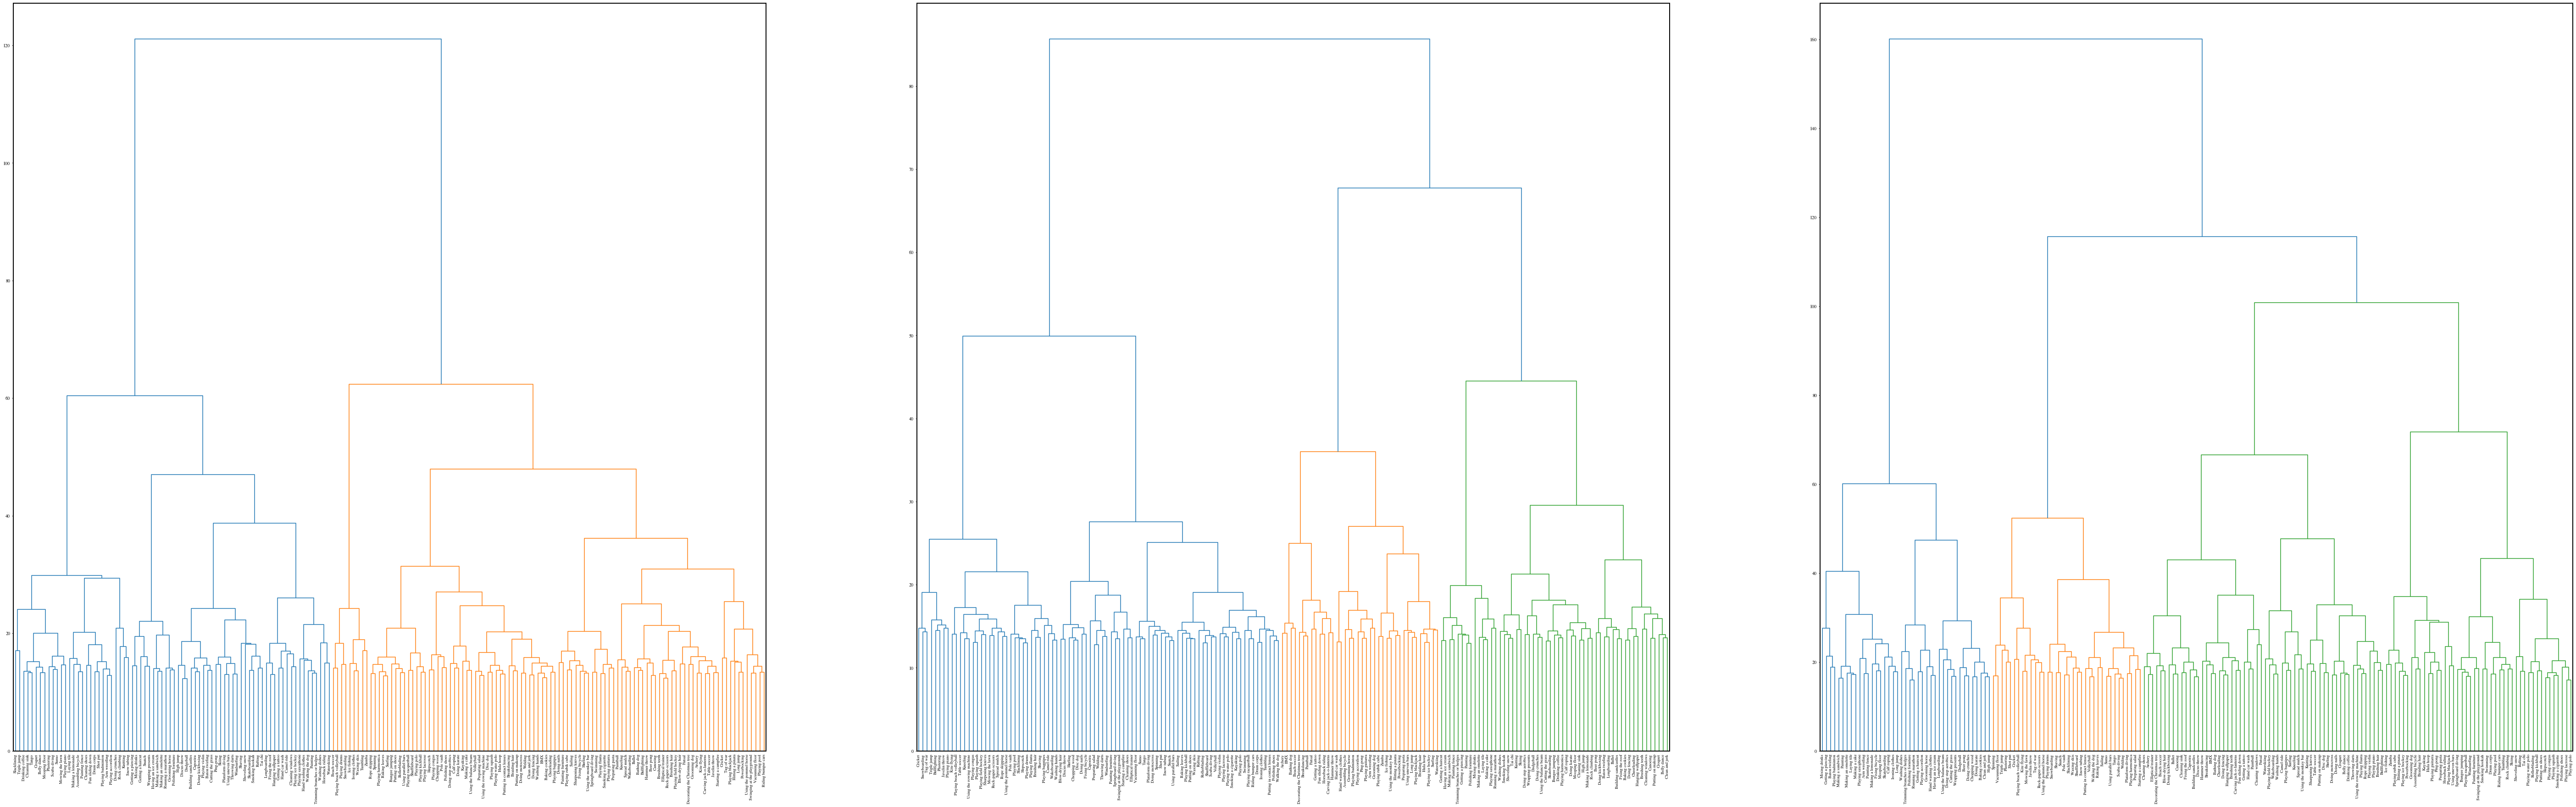

In [21]:
import os
from scipy.cluster import hierarchy 

# define params
method = 'ward'
color_list = [f'C{i}' for i in range(5)]
hierarchy.set_link_color_palette(color_list)
fig, ax = plt.subplots(1, len(roi_sum), figsize=(100, 30))
# multiple plots
for idx, check_roi in enumerate(roi_sum):
    mask = mask_sum[idx]
    class_pattern = beta_voxel_feature[:, mask]
    # plot
    plt.subplot(1, 3, idx+1)
    clusters = hierarchy.linkage(class_pattern, method)
    hierarchy.dendrogram(clusters, labels=class_selected, orientation='top', leaf_font_size=9, leaf_rotation=90)
    print(f'Finish {check_roi}')
plt.show()


#### Low dimensional visualization to check whether different superordinate categories are segregated

/usr/local/neurosoft/anaconda3/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/neurosoft/anaconda3/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/usr/local/neurosoft/anaconda3/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/neurosoft/anaconda3/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/usr/local/neurosoft/anaconda3/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/

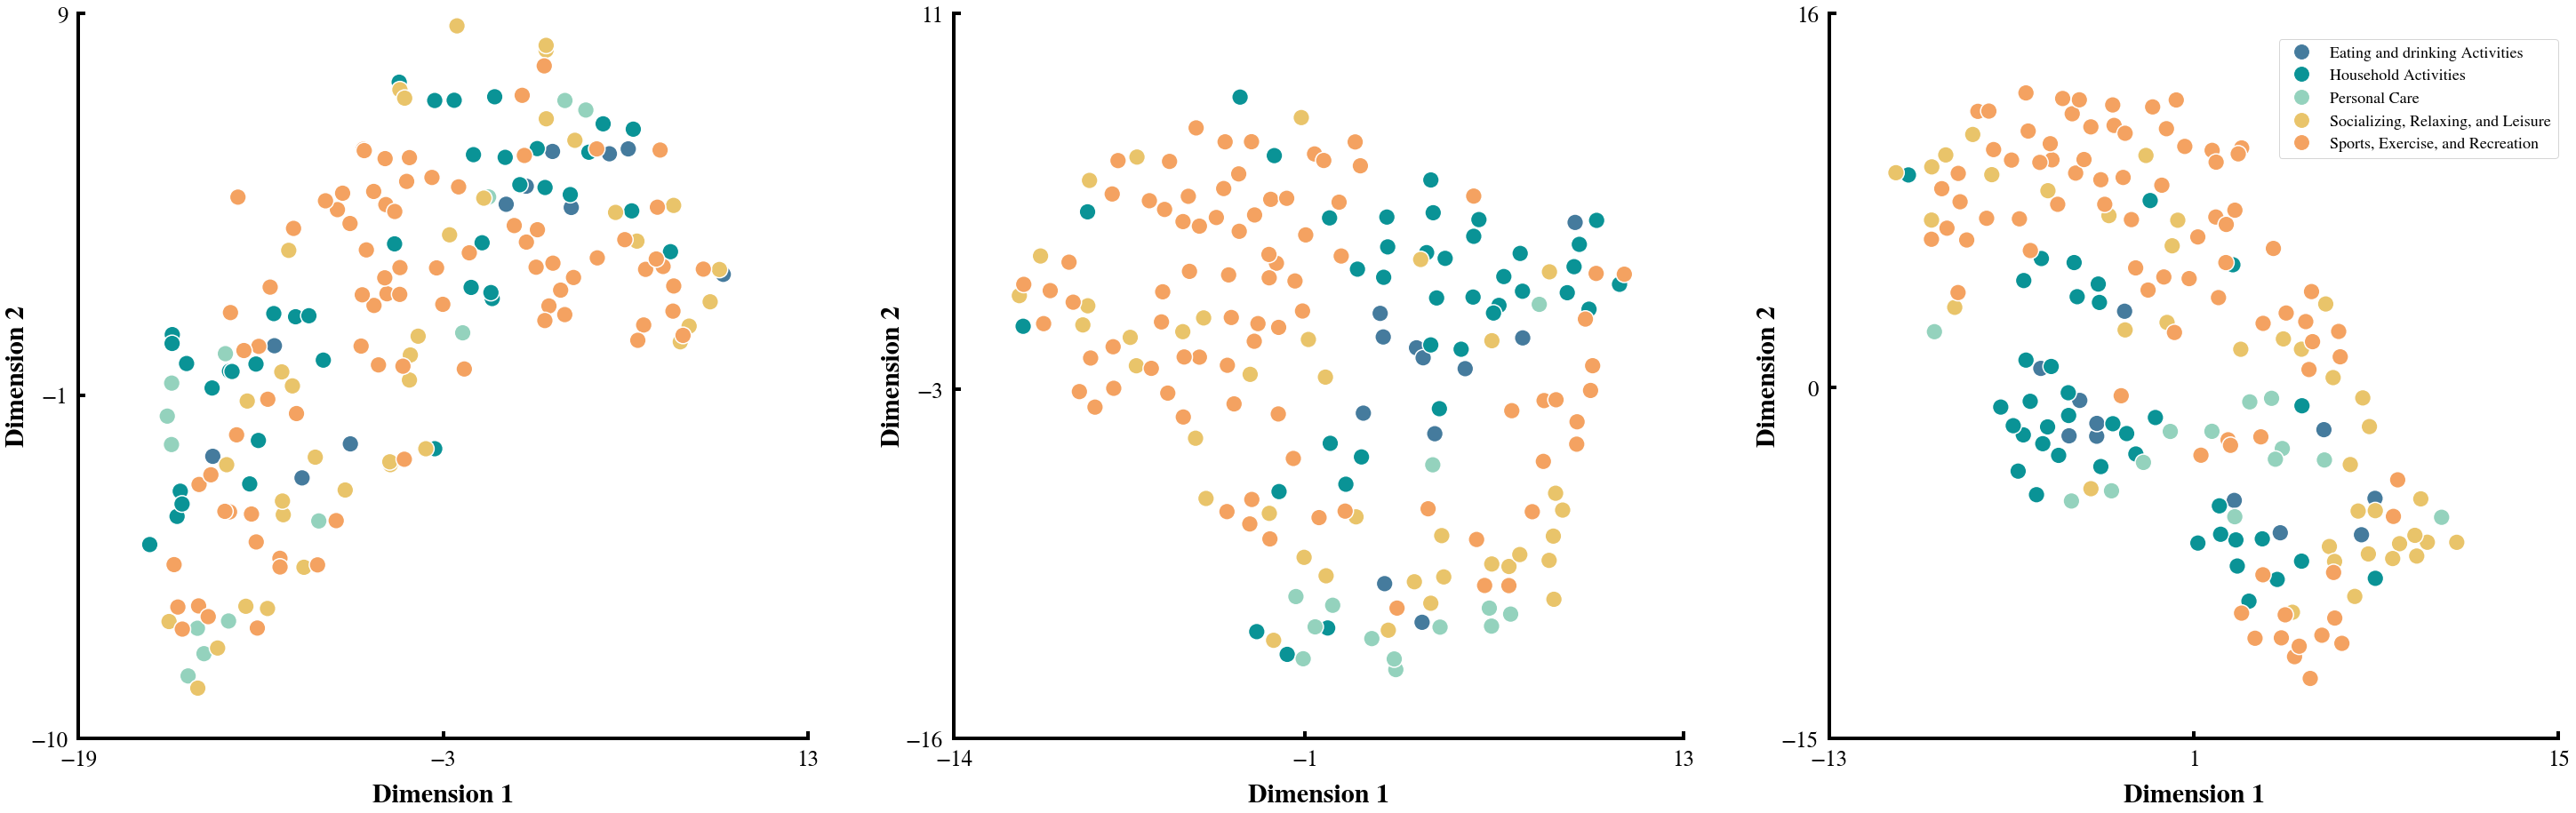

In [44]:
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from matplotlib.lines import Line2D

# define utils
model_name = 'tsne'

# define plot details
fig, ax = plt.subplots(1, len(roi_sum), figsize=(50, 15))
mpl.rcParams['axes.linewidth'] = 2
mpl.rcParams.update({'font.size': 14, 'font.family': 'STIXGeneral', 'mathtext.fontset': 'stix'})
palette = ['#457b9d', '#0a9396', '#94d2bd', '#e9c46a', '#f4a261']
# {'EVC':(-90,110,-50,60), 'VTC':(-70,70,-50,50), 'LO':(-90,110,-50,60), 'AIP':(-90,110,-50,60)}
tick_range = {'EV':(-19,13,-10,9), 'VS':(-14,13,-16,11), 'DS':(-13,15,-15,16)}
# tick_range = {'EV':(-16,16,-12,4), 'VS':(-13,11,-13,15), 'DS':(-12,16,-14,15)}

# superordinate category info
#%% Get super class info used in rdm computation
class_labels = ['Eating and drinking Activities', 'Household Activities', 'Personal Care',
               'Socializing, Relaxing, and Leisure', 'Sports, Exercise, and Recreation']
super_category = [class_labels[x] for x in superclass_order]
custom = [eval(f"Line2D([], [], marker='o', markersize=np.sqrt(250), color='{palette[x]}', linestyle='None')") \
        for x in range(len(class_labels))]

# (-15,15,-15,15)
# specialized voxel loc
for idx, check_roi in enumerate(roi_sum):
    axes = ax[idx]
    mask = mask_sum[idx]
    # specialized voxel loc
    class_pattern = beta_average_sorted[:, mask]
    # Scale and select voxel in data
    scaler = StandardScaler()
    class_pattern = scaler.fit_transform(class_pattern)
    # plot 2 dimensional subspace
    X, y =  class_pattern, super_category
    # define model
    if model_name == 'tsne':
        model = TSNE(n_components=2, n_iter=10000, random_state=123)
    elif model_name == 'pca':
        model = PCA(n_components=2)
    # transform data
    X_transformed = model.fit_transform(X)
    # explained_variance = model.explained_variance_ratio_[:2].sum()
    df = pd.DataFrame()
    df["label"] = y 
    df["comp-1"] = X_transformed[:,0]
    df["comp-2"] = X_transformed[:,1]

    # Select super class to show
    # class_labels_to_show = ['Sports, Exercise, and Recreation']
    # df = df.loc[df['label']==class_labels_to_show[0]]
    # class_order = class_order[df.index.to_numpy()]
    # df.reset_index(drop=True, inplace=True)

    # plot data
    legend = 'brief' if check_roi == 'DS' else False
    canvas = sns.scatterplot(ax=axes, x="comp-1", y="comp-2", hue='label', s=350, legend=legend, data=df,
                            palette=sns.color_palette(palette, 5),) 
                        #sns.color_palette("hls", 4), 
    # annotate class categories 
    # for line in range(0, df.shape[0]):
    #      canvas.text(df.loc[line, 'comp-1']+0.02, df.loc[line, 'comp-2']+0.01, class_order[line], 
    #      horizontalalignment='left', size='medium', color='black', weight='semibold')

    # axes.set_title('%s: %.3f'%(check_roi, explained_variance), fontsize=25)
    axes.set_xlabel('Dimension 1', fontsize=30, labelpad=15, weight='bold')
    axes.set_ylabel('Dimension 2', fontsize=30, labelpad=1, weight='bold')
    axes.tick_params(labelsize=25, width=4, length=8, direction="in", pad=12)
    # axes_range = (-150,150,-150,150)
    axes_range = tick_range[check_roi]
    axes.set_xlim(axes_range[0], axes_range[1])
    axes.set_xticks(np.linspace(axes_range[0], axes_range[1], 3,dtype=int))
    axes.set_ylim(axes_range[2], axes_range[3])
    axes.set_yticks(np.linspace(axes_range[2], axes_range[3], 3,dtype=int))   
    if check_roi == 'DS':
        axes.legend(custom, class_labels, loc='lower right', fontsize=18, bbox_to_anchor=(1.01,0.79))
    # set axes lines
    axes.spines['top'].set_visible(False)
    axes.spines['right'].set_visible(False)
    axes.spines['bottom'].set_linewidth(4)
    axes.spines['left'].set_linewidth(4)


In [ ]:
tick_range = {'EV':(-19,13,-10,9), 'VS':(-14,13,-16,11), 'DS':(-13,16,-15,16)}